# BGS Reference Spectra

The goal of this notebook is to generate a set of ~1000 BGS-like spectra which can serve as a set of reference spectra for the BGS exposure-time model (see, e.g., https://github.com/desihub/desisurvey/issues/77).

The basic methodology is to assign BGS templates to galaxies from the MXXL/BGS mock which lie in the green valley and therefore have an intermediate-strength 4000-A break and weak or no emission lines.  For these types of spectra we expect to have a somewhat lower redshift efficiency, and so they should yield conservative S/N estimates for the survey.

### Preliminaries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import desitarget.mock.io as mockio

In [3]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

In [4]:
%matplotlib inline

In [5]:
sns.set(style='ticks', font_scale=1.4, palette='Set2')
col = sns.color_palette()

### Establish the I/O path, output filename, and random seed.

In [6]:
version = 'v1.0'
refdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'sim', 'bgs-refspec')
refspecfile = os.path.join(refdir, 'bgs-refspec-{}.fits'.format(version))

In [7]:
simseed = 123
simrand = np.random.RandomState(simseed)

In [8]:
nrefspec = 1000

### Read a handful of healpixels from the BGS/MXXL mock.

This mock has the correct redshift distribution and correlation between redshift and apparent magnitude for BGS targets (among many other attributes).  Note that we set the velocity dispersion to a fiducial value of 100 km/s.

In [9]:
mockfile = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'bgs', 'MXXL', 'desi_footprint', 'v0.0.4', 'BGS_r20.6.hdf5')
mockdata = mockio.read_durham_mxxl_hdf5(mockfile, rand=simrand, nside=32, nproc=nproc,
                                        healpixels=[3151,3150,3149,3148])
print(mockdata.keys())

INFO:io.py:859:read_durham_mxxl_hdf5: Assigning healpix pixels with nside = 32
INFO:io.py:869:read_durham_mxxl_hdf5: Trimmed to 38857 BGSs in healpixels [3151, 3150, 3149, 3148]
dict_keys(['SDSS_absmag_r01', 'FILTERNAME', 'Z', 'N_PER_FILE', 'TEMPLATESUBTYPE', 'SDSS_01gr', 'RA', 'MAG', 'MOCKID', 'TEMPLATETYPE', 'TRUESPECTYPE', 'SEED', 'FILES', 'BRICKNAME', 'VDISP', 'DEC', 'OBJID'])


In [10]:
mockdata['VDISP'] = np.repeat(100.0, len(mockdata['RA'])) # [km/s]

In [11]:
def qa_radec():
    fig, ax = plt.subplots()
    ax.scatter(mockdata['RA'], mockdata['DEC'], s=1)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')    

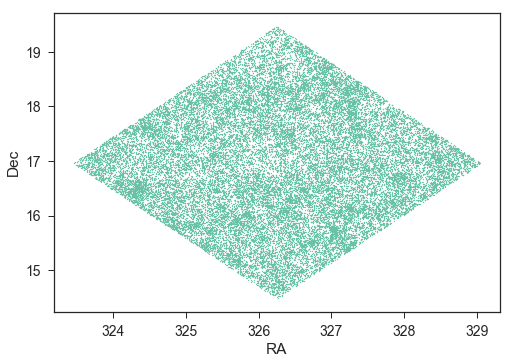

In [12]:
qa_radec()

In [13]:
def qa_zmag():
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    _ = ax[0].hist(mockdata['Z'], bins=100)
    ax[0].set_xlabel('Redshift')
    ax[0].set_ylabel('Number of Galaxies')
    ax[1].scatter(mockdata['Z'], mockdata['MAG'], s=1, alpha=0.75)
    ax[1].axhline(y=20.6, ls='--', color='k')
    ax[1].set_xlabel('Redshift')
    ax[1].set_ylabel(r'$r_{SDSS}$ (AB mag)')

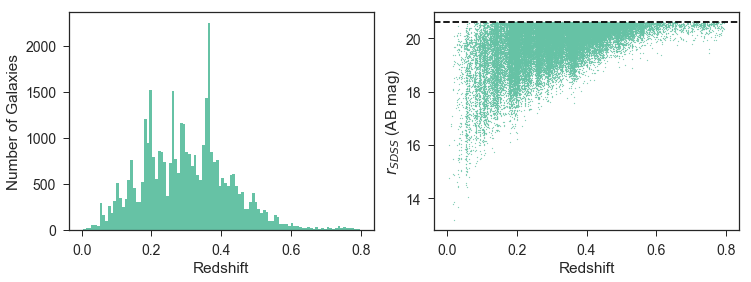

In [14]:
qa_zmag()

### Select galaxies in the green valley.

In [15]:
magaxis = np.arange(-23, -16, 0.1)

In [16]:
def green_valley(Mr, offset=0.0):
    return np.polyval([-0.04, 0.75], Mr+20) + offset

In [17]:
in_greenvalley = np.where(
    (mockdata['SDSS_01gr'] < green_valley(mockdata['SDSS_absmag_r01'], offset=+0.05)) * 
    (mockdata['SDSS_01gr'] > green_valley(mockdata['SDSS_absmag_r01'], offset=-0.05)))[0]    
print('Selected {} / {} green-valley galaxies.'.format(len(in_greenvalley), len(mockdata['RA'])))

Selected 5071 / 38857 green-valley galaxies.


In [18]:
greenvalley_mockdata = dict(Z=mockdata['Z'][in_greenvalley],
                            SEED=mockdata['SEED'][in_greenvalley],
                            MAG=mockdata['MAG'][in_greenvalley],
                            VDISP=mockdata['VDISP'][in_greenvalley],
                            SDSS_absmag_r01=mockdata['SDSS_absmag_r01'][in_greenvalley],
                            SDSS_01gr=mockdata['SDSS_01gr'][in_greenvalley])

In [19]:
def qa_colormag():
    fig, ax = plt.subplots()
    ax.scatter(mockdata['SDSS_absmag_r01'], mockdata['SDSS_01gr'], s=1)
    ax.scatter(mockdata['SDSS_absmag_r01'][in_greenvalley], 
               mockdata['SDSS_01gr'][in_greenvalley], s=1)
    ax.set_xlabel(r'$M_{0.1r}$')
    ax.set_ylabel(r'$^{0.1}(g - r)$')
    ax.set_xlim(-14, -24)
    ax.plot(magaxis, green_valley(magaxis, offset=0.0), color='k', ls='-')
    ax.plot(magaxis, green_valley(magaxis, offset=+0.05), color='k', ls='--')    
    ax.plot(magaxis, green_valley(magaxis, offset=-0.05), color='k', ls='--')        

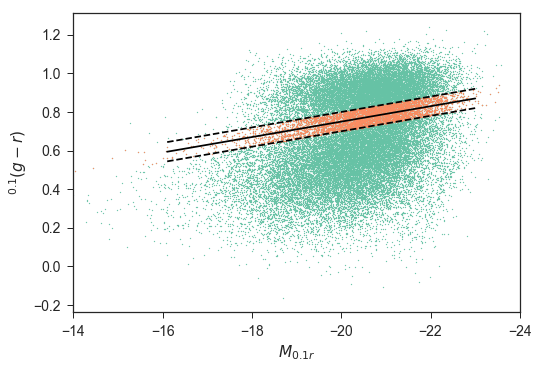

In [20]:
qa_colormag()

### Use a KD tree to assign a basis template to each mock galaxy.
To assign a (continuum) template we use the algorithm developed for the Data Challenge, which uses a simple KD tree constructed from the rest-frame color, magnitude, and redshift of each mock galaxy.  See ```desitarget.mock.spectra``` for more details.

In [21]:
class BGStree(object):
    """Build a KD Tree."""
    def __init__(self):
        from speclite import filters
        from scipy.spatial import cKDTree as KDTree
        from desisim.io import read_basis_templates

        self.bgs_meta = read_basis_templates(objtype='BGS', onlymeta=True)
        self.bgs_tree = KDTree(self._bgs())

    def _bgs(self):
        """Quantities we care about: redshift (z), M_0.1r, and 0.1(g-r).

        """
        zobj = self.bgs_meta['Z'].data
        mabs = self.bgs_meta['SDSS_UGRIZ_ABSMAG_Z01'].data
        rmabs = mabs[:, 2]
        gr = mabs[:, 1] - mabs[:, 2]

        return np.vstack((zobj, rmabs, gr)).T        
    
    def query(self, objtype, matrix, subtype=''):
        """Return the nearest template number based on the KD Tree.

        Args:
          objtype (str): object type
          matrix (numpy.ndarray): (M,N) array (M=number of properties,
            N=number of objects) in the same format as the corresponding
            function for each object type (e.g., self.bgs).
          subtype (str, optional): subtype (only for white dwarfs)

        Returns:
          dist: distance to nearest template
          indx: index of nearest template
        
        """
        if objtype.upper() == 'BGS':
            dist, indx = self.bgs_tree.query(matrix)
        else:
            print('Unrecognized SUBTYPE {}!'.format(subtype))
            raise ValueError
                
        return dist, indx    

In [22]:
class BGStemplates(object):
    """Generate spectra.  

    """
    def __init__(self, wavemin=None, wavemax=None, dw=0.2,
                 rand=None, verbose=False):

        from desimodel.io import load_throughput

        self.tree = BGStree()

        # Build a default (buffered) wavelength vector.
        if wavemin is None:
            wavemin = load_throughput('b').wavemin - 10.0
        if wavemax is None:
            wavemax = load_throughput('z').wavemax + 10.0
            
        self.wavemin = wavemin
        self.wavemax = wavemax
        self.dw = dw
        self.wave = np.arange(round(wavemin, 1), wavemax, dw)

        self.rand = rand
        self.verbose = verbose

        # Initialize the templates once
        from desisim.templates import BGS
        self.bgs_templates = BGS(wave=self.wave, normfilter='sdss2010-r')
        self.bgs_templates.normline = None # no emission lines!
        
    def bgs(self, data, index=None, mockformat='durham_mxxl_hdf5'):
        """Generate spectra for BGS.

        Currently only the MXXL (durham_mxxl_hdf5) mock is supported.  DATA
        needs to have Z, SDSS_absmag_r01, SDSS_01gr, VDISP, and SEED, which are
        assigned in mock.io.read_durham_mxxl_hdf5.  See also BGSKDTree.bgs().

        """
        from desisim.io import empty_metatable

        objtype = 'BGS'
        if index is None:
            index = np.arange(len(data['Z']))
            
        input_meta = empty_metatable(nmodel=len(index), objtype=objtype)
        for inkey, datakey in zip(('SEED', 'MAG', 'REDSHIFT', 'VDISP'),
                                  ('SEED', 'MAG', 'Z', 'VDISP')):
            input_meta[inkey] = data[datakey][index]

        if mockformat.lower() == 'durham_mxxl_hdf5':
            alldata = np.vstack((data['Z'][index],
                                 data['SDSS_absmag_r01'][index],
                                 data['SDSS_01gr'][index])).T
            _, templateid = self.tree.query(objtype, alldata)
        else:
            raise ValueError('Unrecognized mockformat {}!'.format(mockformat))

        input_meta['TEMPLATEID'] = templateid
        flux, _, meta = self.bgs_templates.make_templates(input_meta=input_meta,
                                                          nocolorcuts=True, novdisp=False,
                                                          verbose=self.verbose)

        return flux, meta        

### Generate the templates and write them out.

In [23]:
def bgs_make_templates():
    """Generate the actual templates.  Iterate until we build the desired 
    number of models after target selection.
    
    """
    from astropy.table import vstack
    from desitarget.cuts import isBGS_bright, isBGS_faint
    
    natatime = np.min( (50, nrefspec) )
    ngood = 0
    flux, meta = [], []
    while ngood < nrefspec:
        these = BGSmaker.rand.choice(len(in_greenvalley), natatime)
        flux1, meta1 = BGSmaker.bgs(greenvalley_mockdata, index=these)
            
        keep = np.logical_or( isBGS_bright(rflux=meta1['FLUX_R'].data), 
                             isBGS_faint(rflux=meta1['FLUX_R'].data) )
        ngood1 = np.count_nonzero(keep)
        if ngood1 > 0:
            ngood += ngood1
            flux.append(flux1[keep, :])
            meta.append(meta1[keep])
            
    meta = vstack(meta)[:nrefspec]
    flux = np.vstack(flux)[:nrefspec, :]

    return flux, BGSmaker.wave, meta

In [24]:
BGSmaker = BGStemplates(wavemin=2000, wavemax=1e4, rand=simrand, verbose=False)

INFO:io.py:955:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


In [25]:
%time flux, wave, meta = bgs_make_templates()

CPU times: user 1min 48s, sys: 48.3 s, total: 2min 36s
Wall time: 2min 37s


In [26]:
def plot_subset(nplot=25, ncol=5):
    """Plot a random sampling of the basis templates."""
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = simrand.choice(nspec, nplot, replace=False)
    these = np.sort(these)
    ww = (wave > 5500) * (wave < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(2.2*ncol, 2.2*nrow), sharey=True, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :] / np.median(flux[indx, ww]))
        thisax.text(0.95, 0.93, '{:0d}'.format(indx), ha='right', 
             va='top', transform=thisax.transAxes, fontsize=11)
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

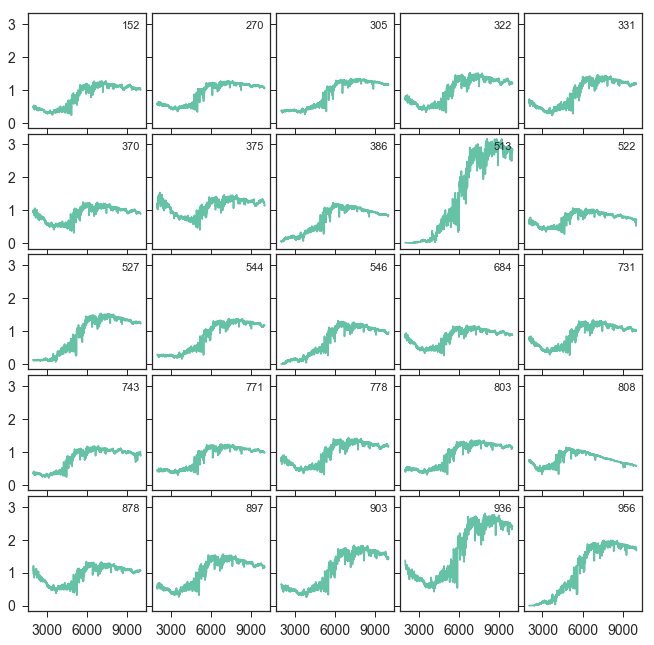

In [27]:
plot_subset()

In [28]:
meta

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
,,,,,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,erg / (cm2 s),erg / (cm2 s),Angstrom,Angstrom,,,,dex,dex,dex,dex,,Gyr,K,m / s2,
str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
BGS,,5643,2761427034,0.216314,19.8273,5.32265,12.8538,23.4667,34.7777,29.8488,-1.0,-1.0,-1.0,-1.0,1.27992,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,4033,2266477326,0.32097,19.5028,6.86763,16.9583,29.0653,36.8275,27.6116,-1.0,-1.0,-1.0,-1.0,1.28163,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,5271,2780375189,0.312467,19.7445,4.64571,13.891,26.3469,36.1345,27.6447,-1.0,-1.0,-1.0,-1.0,1.4155,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,4582,1785568030,0.318508,20.0199,3.75182,10.7044,21.0327,37.4265,30.3113,-1.0,-1.0,-1.0,-1.0,1.28248,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,7016,1891769912,0.40311,19.9954,3.04918,11.332,24.6303,46.6207,34.3481,-1.0,-1.0,-1.0,-1.0,1.42226,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,205,1639244341,0.439215,19.3064,4.83087,22.5878,51.719,78.1767,58.101,-1.0,-1.0,-1.0,-1.0,1.58114,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,3689,218364221,0.108941,19.1904,12.44,22.4007,33.3298,25.5034,17.2214,-1.0,-1.0,-1.0,-1.0,1.26215,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,5167,619028101,0.36221,19.398,5.22356,19.2007,40.3657,64.7244,47.9581,-1.0,-1.0,-1.0,-1.0,1.50369,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [29]:
def write_templates(outfile):
    import astropy.units as u
    from astropy.io import fits

    hx = fits.HDUList()
    hdu_wave = fits.PrimaryHDU(wave)
    hdu_wave.header['EXTNAME'] = 'WAVE'
    hdu_wave.header['BUNIT'] = 'Angstrom'
    hdu_wave.header['AIRORVAC']  = ('vac', 'Vacuum wavelengths')
    hx.append(hdu_wave)    
    
    fluxunits = 1e-17 * u.erg / (u.s * u.cm**2 * u.Angstrom)
    hdu_flux = fits.ImageHDU(1e17 * flux)
    hdu_flux.header['EXTNAME'] = 'FLUX'
    hdu_flux.header['BUNIT'] = str(fluxunits)
    hx.append(hdu_flux)
    
    hdu_meta = fits.table_to_hdu(meta)
    hdu_meta.header['EXTNAME'] = 'METADATA'
    hx.append(hdu_meta)

    print('Writing {}'.format(outfile))
    hx.writeto(outfile, clobber=True)

In [30]:
write_templates(refspecfile)

Writing /Users/ioannis/work/desi/spectro/sim/bgs-refspec/bgs-refspec-v1.0.fits
